## Plot case study

In [1]:
# General
import glob
import os.path
# from pathlib import Path
import re
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Arrays & Displays
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec

# Data treatment
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'save_figs':  False,
}

PTHS = {
    'dsg_pth':          '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'dsg2_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_17102022_with_extra_params.nc',
    'sav_dir':          '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_STEADY_STATE_CRIT/00_PROFILE_INTRO/'
}

In [3]:
dsg = xr.open_dataset(PTHS['dsg_pth'])

### Add intensification parameters
dsg2 = xr.open_dataset(PTHS['dsg2_pth'])
dsg['Vmax_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_smth_IBT']),
    coords={'time': dsg.time}
)
dsg['Vmax_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['Vmax_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_IBT']),
    coords={'time': dsg.time}
)
dsg['R17_dot_smth_IBT'] = xr.DataArray(
    data=np.array(dsg2['R17_dot_smth_IBT']),
    coords={'time': dsg.time}
)

### Kinetic energy
K1_SAR = dsg['Vmax_1D'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R17_1D'] * 1000) ** 2)
K2_SAR = dsg['R17_1D'] * 1000 * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_1D'] ** 2)
K1_IBT = dsg['Vmax_IBT'] * (dsg['Vmax_dot_smth_IBT'] * 3600) * ((dsg['R34_IBT']) ** 2) 
K2_IBT = dsg['R34_IBT'] * (dsg['R17_dot_smth_IBT'] * 1000 * 3600) * (dsg['Vmax_IBT'] ** 2)

dsg['dKdt_SAR'] = K1_SAR + K2_SAR
dsg['dKdt_IBT'] = K1_IBT + K2_IBT

In [4]:
def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

def getColorMap(rgbFile="medspiration.rgb"):
    '''
    Load a RGB palette provided in ascii file
    '''
    colors = []
    nbCol  =0
    for line in open( rgbFile ):
        r,g,b = [int(c) for c in line.split()]
        colors.append( [r/255.,g/255.,b/255.] )
        nbCol += 1
    return( mpl.colors.ListedColormap(colors, name="custom", N=nbCol) )

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    # B     = (Vmax ** 2) * rho * np.e / (pn - pc)
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(np.float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

palette = '/home/arthur/scripts/ck22model/PRJCT_RAD_SCAT_CK22_RMW/high_wind_speed.pal'
cwnd    = getColorMap(rgbFile=palette)

In [5]:
### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
# dsg = dsg.where(dsg.lon_center < -50, drop=True) # Keep only USA best-track agencies
# dsg = dsg.where(dsg.distance_to_coast > 200000, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))
print('SAR Mean R34  = {:.0f} km'.format(dsg.R17_1D.mean()))

Nb of storms: 191
SAR Mean Rmax = 33 km
SAR Mean R64  = 57 km
SAR Mean R34  = 137 km


In [6]:
sat_file = 's1b-ew-owi-cm-20210926t090903-20210926t091107-000003-0371EC_sw.nc'
sar_pth  = '/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1b-ew-owi-ca-20210926t090903-20210926t091107-000003-0371EC_sw_al182021_cyclone.nc'

ds       = dsg.where(dsg.sat_file == sat_file, drop=True).isel(time=0)
dss      = xr.open_dataset(sar_pth).isel(time=0)

In [7]:
### Compute Holland and R0
R0       = np.sqrt(2 * ds.Rmax_1D * 1000 * ds.Vmax_1D / (abs(coriolis(ds.lat_center)))) / 1000
rs       = np.linspace(0, 500000, 50001) # define dr accordingly
Vh       = holland_profile(rs, float(abs(ds.lat_center)), float(ds.pn_hol), float(ds.pc_hol), float(ds.Vmin_hol), float(ds.Rmax_hol), float(ds.Vmax_hol))

Rm Vm^2 / (R0 V0 ^2) = 1.09


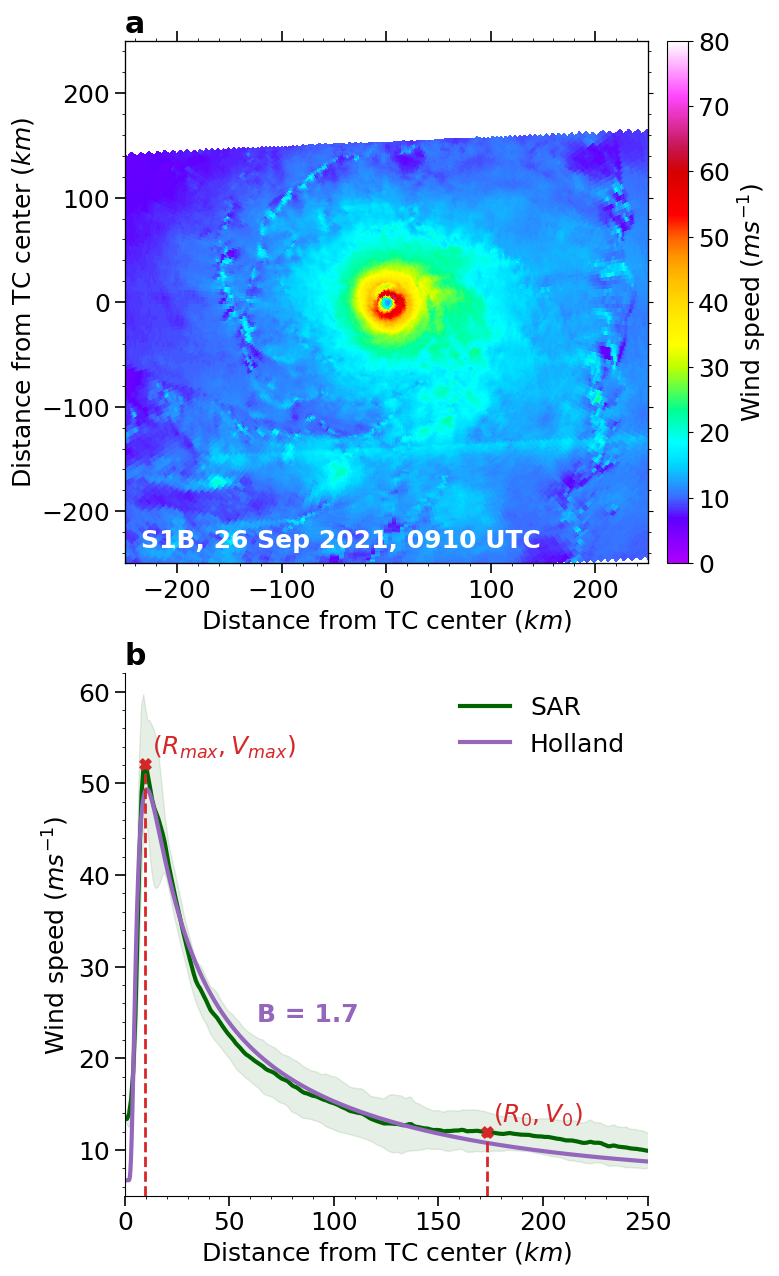

In [8]:
fig        = plt.figure(figsize=(15, 15))
gs         = GridSpec(2, 1, hspace=0.21, wspace=0.1)

cmap       = mpl.cm.get_cmap('PuOr') # Spectral

normalizer = Normalize(0, 80)
# ax_lims2D  = 150
ax_lims2D  = 250

#####################
### 2D WIND FIELD ###
#####################
ax = fig.add_subplot(gs[0, 0])
# ax.set_title('(a) {} - SAR wind field\n'.format(ds.storm_name.item()), weight='bold')
ax.set_title('a', weight='bold', loc='left')
ax.text(0.03, 0.03, 'S1B, 26 Sep 2021, 0910 UTC', transform = ax.transAxes, weight='bold', fontsize=18, c='white')

y_sar, x_sar = pol2cart(dss['rad'], np.deg2rad(dss['theta']))
im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, dss['wind_speed'], cmap=cwnd, norm=normalizer)

ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center ($km$)')
ax.set_xlabel(r'Distance from TC center ($km$)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])



# Colorbar
cb_ax = fig.add_axes([0.7, 0.532, 0.014, 0.348])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed ($m s^{-1}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

################
### PROFILES ###
################
ax = fig.add_subplot(gs[1, 0])
# ax.set_title('(b) {} - Wind profile'.format(ds.storm_name.item()), weight='bold')
ax.set_title('b', weight='bold', loc='left')

spdm_sar = dss.wind_speed.mean(dim='theta', skipna=True)
spds_sar = dss.wind_speed.std(dim='theta', skipna=True)

# SAR
ax.plot(spdm_sar.rad / 1000, spdm_sar, c='darkgreen', linewidth=3, label='SAR')
ax.fill_between(spdm_sar.rad / 1000, spdm_sar - spds_sar, spdm_sar + spds_sar, color='darkgreen', alpha=0.1)
# Holland
ax.plot(rs / 1000, Vh, c='tab:purple', linewidth=3, label='Holland')
ax.text(63, 24, 'B = {:.1f}'.format(ds.B_hol), c='tab:purple', weight='bold')

ax.set_xlim(0, ax_lims2D);ax.set_ylim(5, 62)
ax.set_xlabel(r'Distance from TC center ($km$)')
ax.set_ylabel(r'Wind speed ($m s^{-1}$)')
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.legend(frameon=False)
ax.spines[['right', 'top']].set_visible(False)

# # ==>Vertical lines for wind radii
# # > SAR
# trans = ax.get_xaxis_transform()
# # Rmax
# ax.axvline(spdm_sar.rad[int(spdm_sar.argmax())] / 1000, ymax=0.83,                     c='darkgreen', linewidth=3, linestyle='--')
# ax.text(spdm_sar.rad[int(spdm_sar.argmax())] / 1000 + 2, .02, r'$R_{max}$', c='darkgreen', transform=trans, rotation='vertical')
# # R0
# ax.axvline(R0, ymax=0.127,                   c='forestgreen', alpha=0.5, linewidth=3, linestyle='--')
# ax.text(R0 + 2, .02, r'$R_{0}$', c='forestgreen', alpha=0.5, transform=trans, rotation='vertical')
# # Vmax
# trans = ax.get_yaxis_transform()
# ax.axhline(ds.Vmax_1D, xmax=0.05,                     c='darkgreen', linewidth=3, linestyle='--')
# ax.text(.002, ds.Vmax_1D + 1, r'$V_{max}$', c='darkgreen', transform=trans, rotation='horizontal')
# # V0
# ax.axhline(spdm_sar.sel(rad=R0 * 1000, method='nearest'), xmax=0.87,                   c='forestgreen', alpha=0.5, linewidth=3, linestyle='--')
# ax.text(.002, spdm_sar.sel(rad=R0 * 1000, method='nearest') + 1, r'$V_{0}$', c='forestgreen', alpha=0.5, transform=trans, rotation='horizontal')

# Rmax, Vmax
ax.scatter(spdm_sar.rad[int(spdm_sar.argmax())] / 1000 - 0.3, ds.Vmax_1D, color='tab:red', marker='X', s=65, zorder=2)
ax.text(spdm_sar.rad[int(spdm_sar.argmax())] / 1000 + 3, ds.Vmax_1D + 1, r'($R_{max}, V_{max}$)', c='tab:red')
ax.axvline(spdm_sar.rad[int(spdm_sar.argmax())] / 1000 - 0.3, ymax=0.83,                     c='tab:red', linewidth=2, linestyle='--')
# R0, V0
ax.scatter(R0 - 0.3, spdm_sar.sel(rad=R0 * 1000, method='nearest'), color='tab:red', marker='X', s=65, zorder=2)
ax.text(R0 + 3, spdm_sar.sel(rad=R0 * 1000, method='nearest') + 1, r'($R_{0}, V_{0}$)', c='tab:red')
ax.axvline(R0 - 0.3, ymax=0.13,                     c='tab:red', linewidth=2, linestyle='--')

print('Rm Vm^2 / (R0 V0 ^2) = {:.2f}'.format(ds.Rmax_1D * (ds.Vmax_1D ** 2) / (R0 * (spdm_sar.sel(rad=R0 * 1000, method='nearest') ** 2))))

if PRMS['save_figs']:
    # plt.savefig(PTHS['sav_dir'] + 'profile_intro.eps', bbox_inches='tight', format='eps')
    # plt.savefig(PTHS['sav_dir'] + 'profile_intro.pdf', bbox_inches='tight', format='pdf')
    plt.savefig(PTHS['sav_dir'] + 'profile_intro', bbox_inches='tight')

In [9]:
rs       = np.linspace(0, 500000, 50001) # define dr accordingly
# Sam
sat_file = 's1b-ew-owi-cm-20210926t090903-20210926t091107-000003-0371EC_sw.nc'
sar_pth  = '/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1b-ew-owi-ca-20210926t090903-20210926t091107-000003-0371EC_sw_al182021_cyclone.nc'
sam      = dsg.where(dsg.sat_file == sat_file, drop=True).isel(time=0)
sams     = xr.open_dataset(sar_pth).isel(time=0)
R0_sam   = np.sqrt(2 * sam.Rmax_1D * 1000 * sam.Vmax_1D / (abs(coriolis(sam.lat_center)))) / 1000
Vh_sam   = holland_profile(rs, float(abs(sam.lat_center)), float(sam.pn_hol), float(sam.pc_hol), float(sam.Vmin_hol), float(sam.Rmax_hol), float(sam.Vmax_hol))
# Wutip
sat_file = 's1b-ew-owi-cm-20190223t202348-20190223t202552-000003-01C2E0_sw.nc'
sar_pth  = '/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1b-ew-owi-ca-20190223t202348-20190223t202552-000003-01C2E0_sw_wp022019_cyclone.nc'
wutip    = dsg.where(dsg.sat_file == sat_file, drop=True).isel(time=0)
wutips   = xr.open_dataset(sar_pth).isel(time=0)
R0_wutip = np.sqrt(2 * wutip.Rmax_1D * 1000 * wutip.Vmax_1D / (abs(coriolis(wutip.lat_center)))) / 1000
Vh_wutip = holland_profile(rs, float(abs(wutip.lat_center)), float(wutip.pn_hol), float(wutip.pc_hol), float(wutip.Vmin_hol), float(wutip.Rmax_hol), float(wutip.Vmax_hol))

In [10]:
# # Sergio
# sat_file = 's1a-ew-owi-cm-20181003t134006-20181003t134210-000003-029E52_sw.nc'
# sar_pth  = '/home/arthur/data/cyclobs/centered_rotated_files_31012022/s1a-ew-owi-ca-20181003t134006-20181003t134210-000003-029E52_sw_ep212018_cyclone.nc'
# wutip    = dsg.where(dsg.sat_file == sat_file, drop=True).isel(time=0)
# wutips   = xr.open_dataset(sar_pth).isel(time=0)
# R0_wutip = np.sqrt(2 * wutip.Rmax_1D * 1000 * wutip.Vmax_1D / (abs(coriolis(wutip.lat_center)))) / 1000
# Vh_wutip = holland_profile(rs, float(abs(wutip.lat_center)), float(wutip.pn_hol), float(wutip.pc_hol), float(wutip.Vmin_hol), float(wutip.Rmax_hol), float(wutip.Vmax_hol))

In [11]:
# # Andres
# sat_file = 'rs2--owi-cm-20150601t015945-20150601t020101-00003-BDBF8_sw.nc'
# sar_pth  = '/home/arthur/data/cyclobs/centered_rotated_files_31012022/rs2--owi-ca-20150601t015945-20150601t020101-00003-BDBF8_sw_ep012015_cyclone.nc'
# wutip    = dsg.where(dsg.sat_file == sat_file, drop=True).isel(time=0)
# wutips   = xr.open_dataset(sar_pth).isel(time=0)
# R0_wutip = np.sqrt(2 * wutip.Rmax_1D * 1000 * wutip.Vmax_1D / (abs(coriolis(wutip.lat_center)))) / 1000
# Vh_wutip = holland_profile(rs, float(abs(wutip.lat_center)), float(wutip.pn_hol), float(wutip.pc_hol), float(wutip.Vmin_hol), float(wutip.Rmax_hol), float(wutip.Vmax_hol))

Rm Vm^2 / (R0 V0 ^2) = 1.09
Rm Vm^2 / (R0 V0 ^2) = 0.73


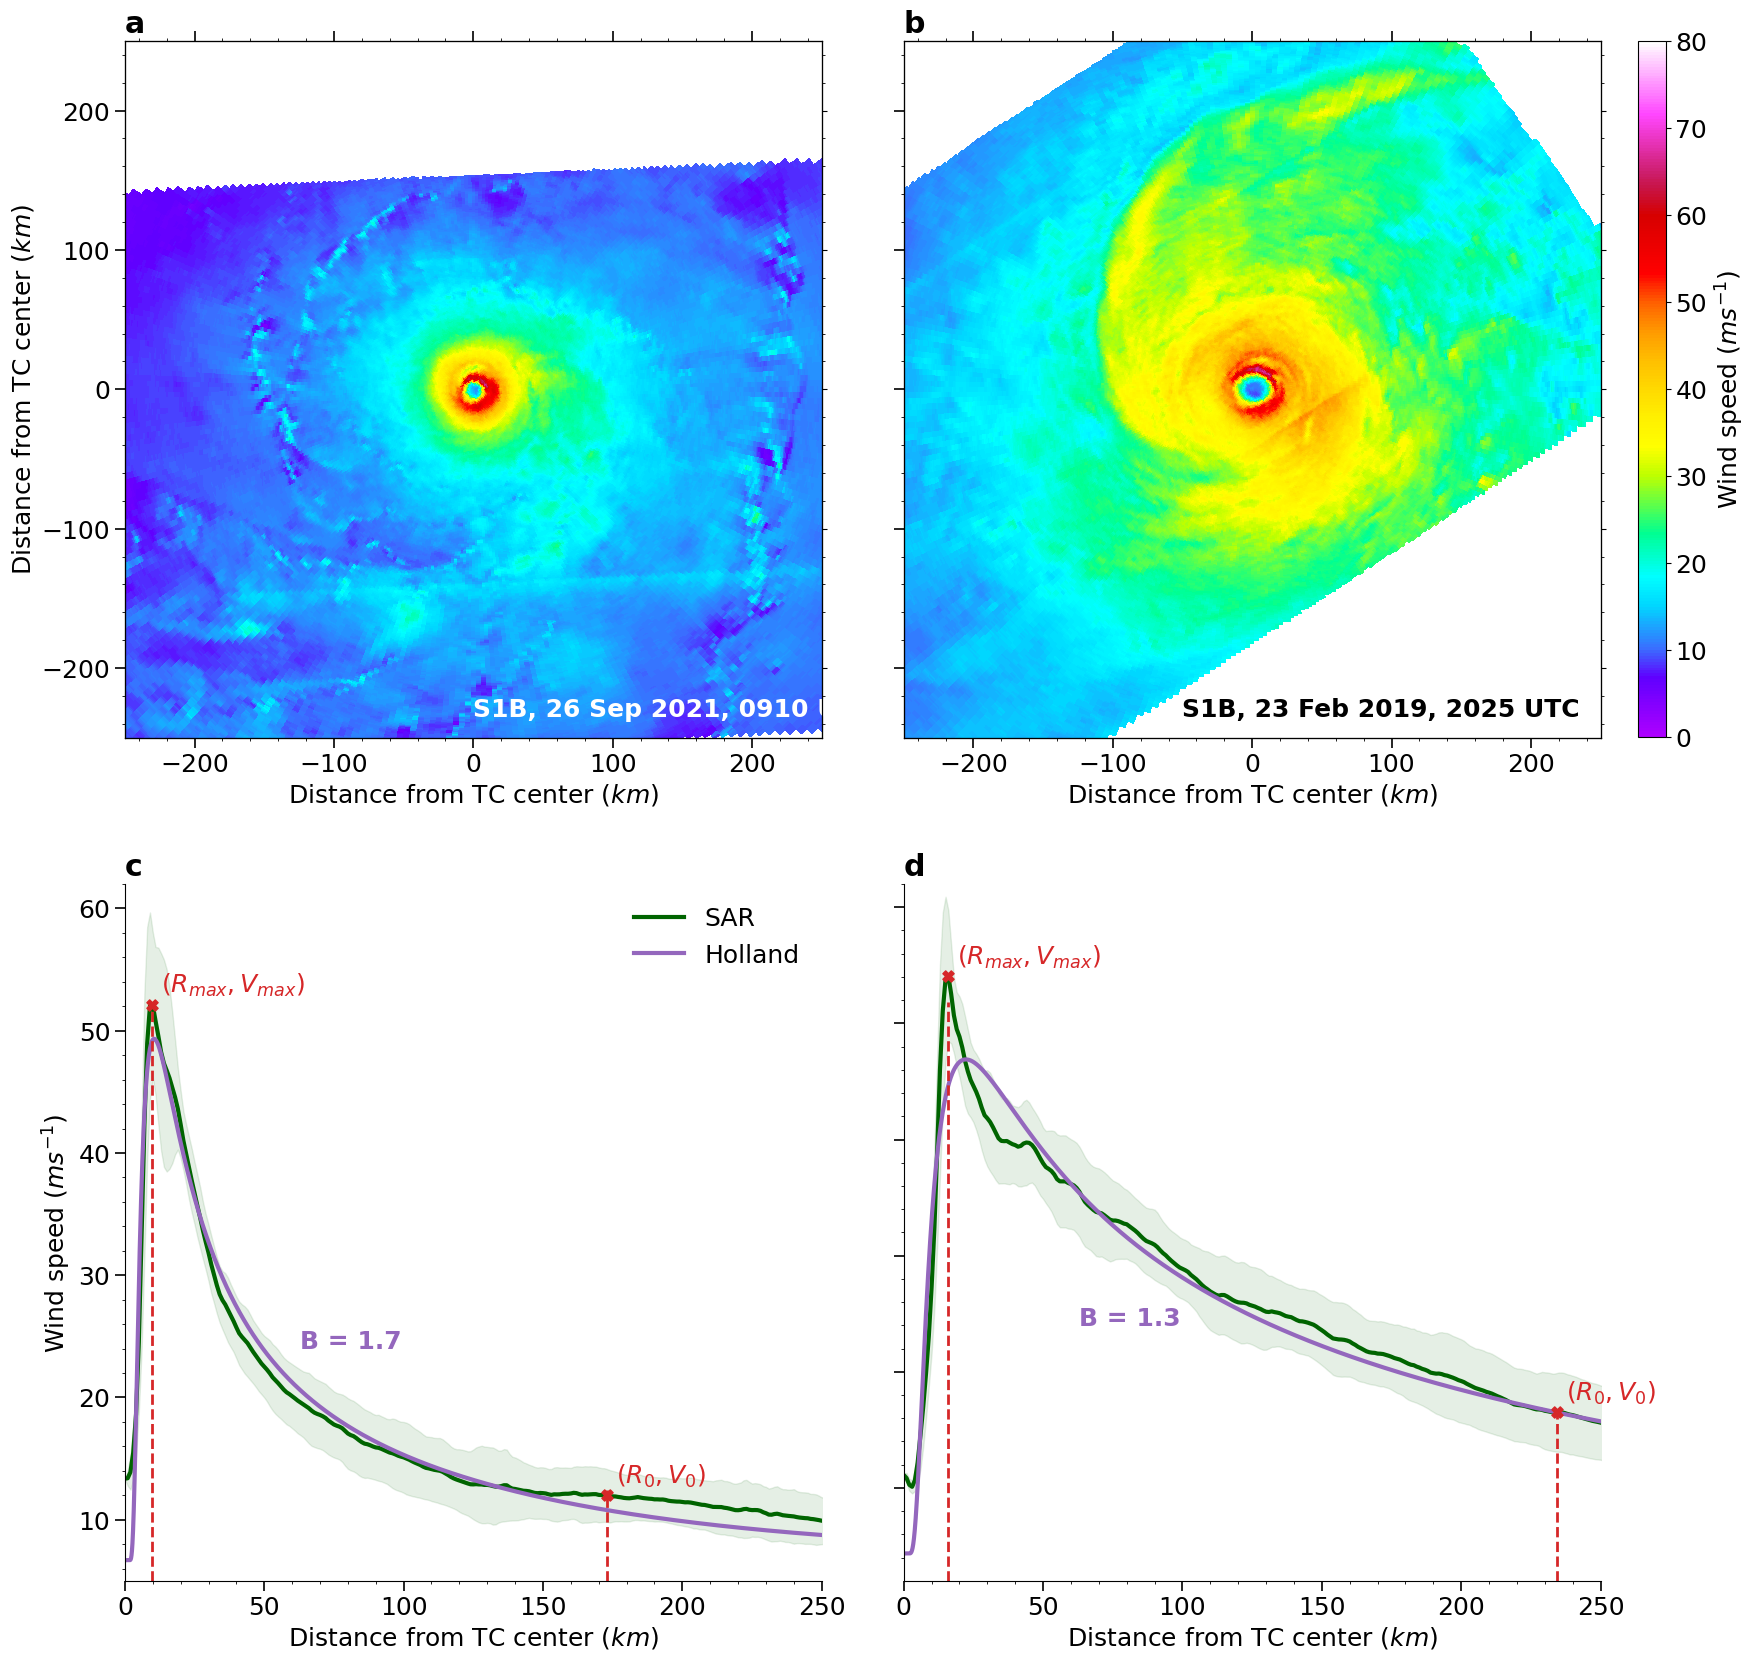

In [12]:
fig        = plt.figure(figsize=(20, 20))
gs         = GridSpec(2, 2, hspace=0.21, wspace=0.01)

cmap       = mpl.cm.get_cmap('PuOr') # Spectral

normalizer = Normalize(0, 80)
# ax_lims2D  = 150
ax_lims2D  = 250

#####################
### 2D WIND FIELD ###
#####################

### SAM
ax = fig.add_subplot(gs[0, 0])
ax.set_title('a', weight='bold', loc='left')
ax.text(0.5, 0.03, 'S1B, 26 Sep 2021, 0910 UTC', transform = ax.transAxes, weight='bold', fontsize=18, c='white')

y_sar, x_sar = pol2cart(sams['rad'], np.deg2rad(sams['theta']))
im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, sams['wind_speed'], cmap=cwnd, norm=normalizer)

ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_ylabel(r'Distance from TC center ($km$)')
ax.set_xlabel(r'Distance from TC center ($km$)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

### WUTIP
ax = fig.add_subplot(gs[0, 1])
ax.set_title('b', weight='bold', loc='left')
ax.text(0.4, 0.03, 'S1B, 23 Feb 2019, 2025 UTC', transform = ax.transAxes, weight='bold', fontsize=18, c='k')

y_sar, x_sar = pol2cart(wutips['rad'], np.deg2rad(wutips['theta']))
im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, wutips['wind_speed'], cmap=cwnd, norm=normalizer)

ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
# ax.set_ylabel(r'Distance from TC center ($km$)')
ax.set_yticklabels([])
ax.set_xlabel(r'Distance from TC center ($km$)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=7, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])


# Colorbar
cb_ax = fig.add_axes([0.9, 0.532, 0.014, 0.348])
cbar  = fig.colorbar(im, cax=cb_ax)
cbar.set_label(r'Wind speed ($m s^{-1}$)', rotation=90)
cbar.ax.get_yaxis().labelpad=5

################
### PROFILES ###
################

### SAM
ax = fig.add_subplot(gs[1, 0])
# ax.set_title('(b) {} - Wind profile'.format(ds.storm_name.item()), weight='bold')
ax.set_title('c', weight='bold', loc='left')

spdm_sar = sams.wind_speed.mean(dim='theta', skipna=True)
spds_sar = sams.wind_speed.std(dim='theta', skipna=True)

# SAR
ax.plot(spdm_sar.rad / 1000, spdm_sar, c='darkgreen', linewidth=3, label='SAR')
ax.fill_between(spdm_sar.rad / 1000, spdm_sar - spds_sar, spdm_sar + spds_sar, color='darkgreen', alpha=0.1)
# Holland
ax.plot(rs / 1000, Vh_sam, c='tab:purple', linewidth=3, label='Holland')
ax.text(63, 24, 'B = {:.1f}'.format(sam.B_hol), c='tab:purple', weight='bold')

ax.set_xlim(0, ax_lims2D);ax.set_ylim(5, 62)
ax.set_xlabel(r'Distance from TC center ($km$)')
ax.set_ylabel(r'Wind speed ($m s^{-1}$)')
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
ax.legend(frameon=False)
ax.spines[['right', 'top']].set_visible(False)

# Rmax, Vmax
ax.scatter(spdm_sar.rad[int(spdm_sar.argmax())] / 1000 - 0.3, sam.Vmax_1D, color='tab:red', marker='X', s=65, zorder=2)
ax.text(spdm_sar.rad[int(spdm_sar.argmax())] / 1000 + 3, sam.Vmax_1D + 1, r'($R_{max}, V_{max}$)', c='tab:red')
ax.axvline(spdm_sar.rad[int(spdm_sar.argmax())] / 1000 - 0.3, ymax=0.83,                     c='tab:red', linewidth=2, linestyle='--')
# R0, V0
ax.scatter(R0_sam - 0.3, spdm_sar.sel(rad=R0_sam * 1000, method='nearest'), color='tab:red', marker='X', s=65, zorder=2)
ax.text(R0_sam + 3, spdm_sar.sel(rad=R0_sam * 1000, method='nearest') + 1, r'($R_{0}, V_{0}$)', c='tab:red')
ax.axvline(R0_sam - 0.3, ymax=0.13,                     c='tab:red', linewidth=2, linestyle='--')

print('Rm Vm^2 / (R0 V0 ^2) = {:.2f}'.format(sam.Rmax_1D * (sam.Vmax_1D ** 2) / (R0_sam * (spdm_sar.sel(rad=R0_sam * 1000, method='nearest') ** 2))))

### WUTIP
ax = fig.add_subplot(gs[1, 1])
# ax.set_title('(b) {} - Wind profile'.format(ds.storm_name.item()), weight='bold')
ax.set_title('d', weight='bold', loc='left')

spdm_sar = wutips.wind_speed.mean(dim='theta', skipna=True)
spds_sar = wutips.wind_speed.std(dim='theta', skipna=True)

# SAR
ax.plot(spdm_sar.rad / 1000, spdm_sar, c='darkgreen', linewidth=3, label='SAR')
ax.fill_between(spdm_sar.rad / 1000, spdm_sar - spds_sar, spdm_sar + spds_sar, color='darkgreen', alpha=0.1)
# Holland
ax.plot(rs / 1000, Vh_wutip, c='tab:purple', linewidth=3, label='Holland')
ax.text(63, 24, 'B = {:.1f}'.format(wutip.B_hol), c='tab:purple', weight='bold')

ax.set_xlim(0, ax_lims2D);ax.set_ylim(2, 62)
ax.set_xlabel(r'Distance from TC center ($km$)')
ax.set_yticklabels([])
# ax.set_ylabel(r'Wind speed ($m s^{-1}$)')
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(length=7, width=1.2)
# ax.legend(frameon=False)
ax.spines[['right', 'top']].set_visible(False)

# Rmax, Vmax
ax.scatter(spdm_sar.rad[int(spdm_sar.argmax())] / 1000 - 0.3, wutip.Vmax_1D, color='tab:red', marker='X', s=65, zorder=2)
ax.text(spdm_sar.rad[int(spdm_sar.argmax())] / 1000 + 3, wutip.Vmax_1D + 1, r'($R_{max}, V_{max}$)', c='tab:red')
ax.axvline(spdm_sar.rad[int(spdm_sar.argmax())] / 1000 - 0.3, ymax=0.83,                     c='tab:red', linewidth=2, linestyle='--')
# R0, V0
ax.scatter(R0_wutip - 0.3, spdm_sar.sel(rad=R0_wutip * 1000, method='nearest'), color='tab:red', marker='X', s=65, zorder=2)
ax.text(R0_wutip + 3, spdm_sar.sel(rad=R0_wutip * 1000, method='nearest') + 1, r'($R_{0}, V_{0}$)', c='tab:red')
ax.axvline(R0_wutip - 0.3, ymax=0.24,                     c='tab:red', linewidth=2, linestyle='--')

print('Rm Vm^2 / (R0 V0 ^2) = {:.2f}'.format(wutip.Rmax_1D * (wutip.Vmax_1D ** 2) / (R0_wutip * (spdm_sar.sel(rad=R0_wutip * 1000, method='nearest') ** 2))))

# plt.savefig(PTHS['sav_dir'] + 'profile_intro_2cases.pdf', bbox_inches='tight', format='pdf', dpi=200)

if PRMS['save_figs']:
    # plt.savefig(PTHS['sav_dir'] + 'profile_intro.eps', bbox_inches='tight', format='eps')
    # plt.savefig(PTHS['sav_dir'] + 'profile_intro.pdf', bbox_inches='tight', format='pdf')
    plt.savefig(PTHS['sav_dir'] + 'profile_intro', bbox_inches='tight')